# Exploratory Data Analysis of Pro-Level League of Legends Matches
***

The data being used was obtained from [Oracle's Elixer] (using upload from September 18th). A [codebook] for the variables is also included.

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

## Getting the data and preparing the workspace

First I will import all neccessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Then I will download a series of .xlsx links, read them into a pandas dataframe and concatenate them together. I will also save this initial dataset for reproducibility (and for consistency in the event the original .xlsx files are updated as I build out my analysis).

In [14]:
# List of excel file url's to read and join together
# root_url = "http://oracleselixir.com/gamedata/"
# urls = ["2016-spring/", "2017-spring/", "2017-summer/"]
# urls = [root_url + url for url in urls]

# reqs = [pd.read_excel(url, 'Sheet1') for url in urls]
# partial_dfs = [pd.read_excel(req, 'Sheet1') for req in reqs]
# df = pd.concat(partial_dfs, ignore_index = True)

# Save df as a csv for future work.
# df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Raw-LoL-Data.csv')

# Read df from csv if the files have been updated.
df = pd.read_csv('C:/Users/glander/Documents/DataScience/Springboard/Capstone1/Raw-LoL-Data.csv', encoding = "ISO-8859-1", index_col = 0)

C:\Users\glander\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,18,19,34,35,36,37,71,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Processing the data
***
I'll take a quick look at the dataset.

In [15]:
print(df.head(10))
print(df.info())

    gameid                                                url league   split  \
0  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
1  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
2  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
3  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
4  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
5  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
6  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
7  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
8  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
9  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   

           date  week game  patchno  playerid  side   ...         cspm  \
0  42578.113113  10.3    1     6.14         1

As there are 33 object type columns that correspond to either numeric or categorical variables, they need to be recast for analysis. There are also two numeric types (patchno and playerid) that need to be coerced to categorical variables.

In [16]:
#Filter object type columns that will be converted to numeric.
objCols = df.columns[df.dtypes == object][16:]

for col in objCols:
    try:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    except:
        print('Column {} cannot be converted to numeric.'.format(col))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null object
split                      64692 non-null object
date                       57937 non-null float64
week                       64692 non-null object
game                       64692 non-null object
patchno                    64692 non-null float64
playerid                   64692 non-null int64
side                       64692 non-null object
position                   64692 non-null object
player                     64692 non-null object
team                       64692 non-null object
champion                   64692 non-null object
ban1                       64506 non-null object
ban2                       64626 non-null object
ban3                       64518 non-null object
ban4                       35874 non-null object
ban5    

In [17]:
#Filter object type columns that will be converted to categorical dtype.
objCols = list(df.columns[df.dtypes == object][2:16])
objCols += ['patchno', 'playerid']
print(objCols)

for col in objCols:
    try:
        df[col] = df[col].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))
print(df.info())

['league', 'split', 'week', 'game', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'patchno', 'playerid']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null category
split                      64692 non-null category
date                       57937 non-null float64
week                       64692 non-null category
game                       64692 non-null category
patchno                    64692 non-null category
playerid                   64692 non-null category
side                       64692 non-null category
position                   64692 non-null category
player                     64692 non-null category
team                       64692 non-null category
champion                   64692 non-null category
ban1                       64506 

#### NOTE - 'date' column conversion error:

The 'date column was originally being read as a float. My guess was that this meant pandas was taking a date like 2017/04/23 and interpretting it as: $\frac{2017}{\frac{4}{23}} $

I attempted to read in the 'date' column as a string to see how it was formatted so that I would know the correct parsing syntax to read it as a datetime. However, the problem with the date showing up as a float still remained. I tried looking at the column in one of the smaller .xlsx files directly and the problem was present even there, leading my to suspect the entire column was miscast when the dataset was created.

In [18]:
# from urllib.request import Request, urlopen

# req = Request("http://oracleselixir.com/gamedata/2017-spring/", headers={'User-Agent': 'Mozilla/5.0'})
# webpage = urlopen(req).read()

# dateTest = pd.ExcelFile(webpage)
# rows = dateTest.book.sheet_by_index(0).nrows
# nrows = 10
# dateTestDF = pd.read_excel(dateTest, 'Sheet1', skip_footer = (rows - nrows - 1), usecols = ['date'], dtype = {'date': str})

# print(dateTestDF)
# print(dateTestDF.info())
# print(type(dateTestDF.iloc[0,0]))

***
#### Segmenting the data:

Now that the column data types have been properly coerced, I will split the data into two separate data frames - one for team level data and the other for individual player data.

In [19]:
teamDF = df[df['player'] == 'Team']
playerDF = df[df['player'] != 'Team']

## Exploratory Data Analysis
***

I'll start by looking at a heatmap of the correlation matrix for `teamDF`. It appears there are a lot of strongly correlated variables, but it's difficult to see which they are due to the large number of variables.

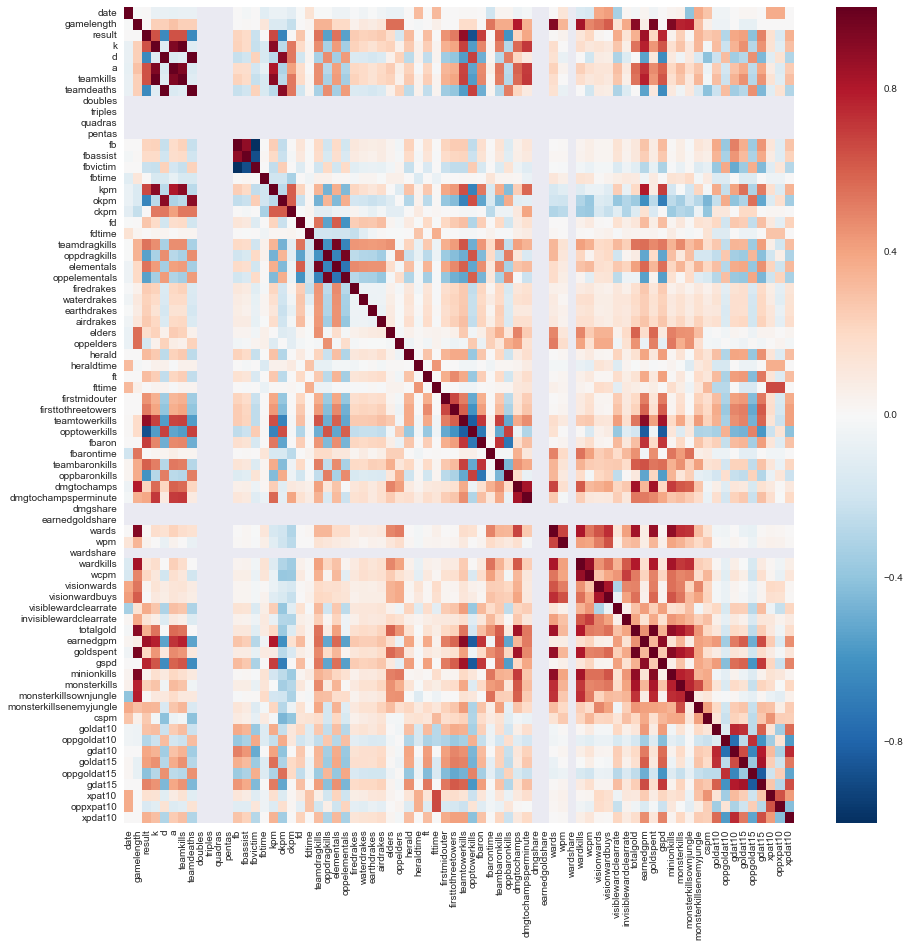

In [20]:
corr = teamDF.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

I'd like to reduce the number of columns I'm using to get a clearer picture. Rather than looking at all of the individual correlations between columns, I'm mostly interested in how the columns correlate with the 'result' column.

First I'll explore this numerically, to see which columns are the most strongly correlated to the response.

In [21]:
print(teamDF.corrwith(teamDF[['result']]))

a                       NaN
airdrakes               NaN
ckpm                    NaN
cspm                    NaN
d                       NaN
date                    NaN
dmgshare                NaN
dmgtochamps             NaN
dmgtochampsperminute    NaN
doubles                 NaN
earnedgoldshare         NaN
earnedgpm               NaN
earthdrakes             NaN
elders                  NaN
elementals              NaN
fb                      NaN
fbaron                  NaN
fbarontime              NaN
fbassist                NaN
fbtime                  NaN
fbvictim                NaN
fd                      NaN
fdtime                  NaN
firedrakes              NaN
firstmidouter           NaN
firsttothreetowers      NaN
ft                      NaN
fttime                  NaN
gamelength              NaN
gdat10                  NaN
                       ... 
okpm                    NaN
oppbaronkills           NaN
oppdragkills            NaN
oppelders               NaN
oppelementals       

Unfortunately, (I think) because the 'result' column contains binary categorical data, the default pearson correlation method doesn't work here.

Instead, I'll try to look at correlation through Point-Biserial Correlation Coefficient.

In [22]:
# After lots of headbanging, I realized that Point-Biserial won't work for comparing
# dichotomous data with an array of object type. For now I've just dropped all columns
# of that type from the correlation analysis. But I'll revisit this later, as there are
# definitely important, potential predictors being dropped.

numCols = teamDF.columns[teamDF.dtypes == np.number]

corrResult = [stats.pointbiserialr(teamDF[['result']][pd.notnull(teamDF[col])], teamDF[[col]][pd.notnull(teamDF[col])])[0] for col in numCols]
corrResult = [n[0] for n in corrResult]
corrResult = pd.Series(corrResult, index = numCols)
corrResult = corrResult.dropna()
print(corrResult.sort_values())

C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\glander\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x =

opptowerkills             -0.882038
okpm                      -0.658117
oppbaronkills             -0.600284
oppdragkills              -0.544083
oppelementals             -0.541514
oppgoldat15               -0.413154
oppgoldat10               -0.291724
fbvictim                  -0.223947
oppelders                 -0.174521
oppxpat10                 -0.150927
date                       0.000000
fttime                     0.000000
heraldtime                 0.000000
fbarontime                 0.000000
fdtime                     0.000000
ckpm                       0.000000
gamelength                 0.000000
fbtime                     0.000000
visionwardbuys             0.004010
wards                      0.010475
monsterkillsownjungle      0.014367
visionwards                0.025927
wpm                        0.039214
minionkills                0.045806
wardkills                  0.119385
invisiblewardclearrate     0.135190
xpat10                     0.150927
elders                     0

Finally, we can create a readable heatmap for the features most correlated (positively and negatively) with result.

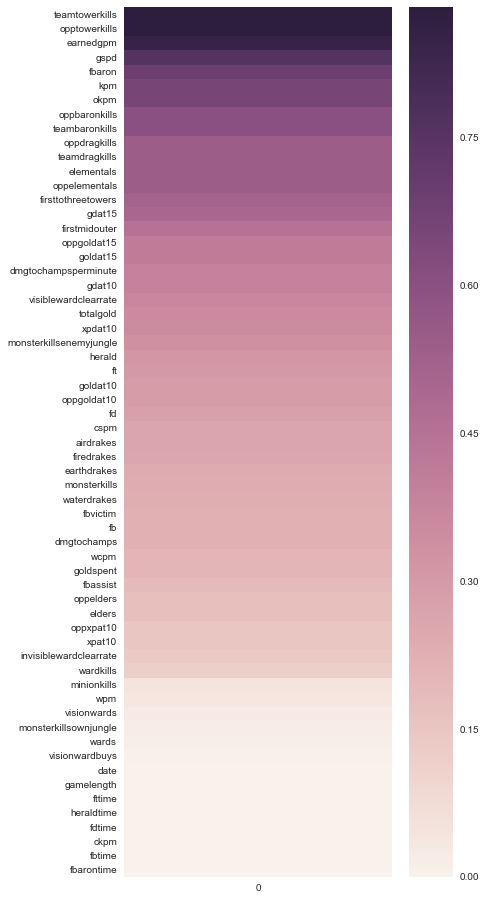

In [23]:
plt.figure(figsize=(6, 16))
sns.heatmap(pd.DataFrame(abs(corrResult)).sort_values(by = 0, ascending = False))
plt.show()

### Further processing the data
***

Next we will look at the team data grouped by unique teams.

In [24]:
teamRecords = teamDF[['result']].groupby(teamDF['team']).mean()

teamRecords.columns = ['winPct']

print(teamRecords.sort_values(by = 'winPct').head(20))

print(teamRecords.sort_values(by = 'winPct').tail(20))

                      winPct
team                        
Eanix               0.000000
Team Gates          0.000000
Besiktas            0.000000
T Show E-Sports     0.000000
Seoul City          0.000000
RisingStar Gaming   0.000000
Chungcheongnam      0.000000
Cougar eSports      0.035714
Hyper Youth Gaming  0.090909
Mousesports         0.100000
Team Mist           0.107143
Kaos Latin Gamers   0.142857
Delta Fox           0.181818
Mysterious Monkeys  0.194444
Fire Ball           0.196970
Enemy               0.200000
Nerv                0.200000
SK Gaming           0.200000
SBENU Sonicboom     0.204545
Cilekler            0.214286
                       winPct
team                         
Hard Random          0.625000
KT Rolster           0.626126
INTZ                 0.630137
J Team               0.631579
RED Canids           0.631579
Immortals            0.644068
Royal Never Give Up  0.648352
G2 Esports           0.651282
Team oNe e-Sports    0.652174
SuperMassive         0.654762
IN

I'll store team win percentages in new columns for later analysis.

In [25]:
teamDF["winRate"] = teamDF["team"].map(teamRecords['winPct'])
playerDF["teamWinRate"] = playerDF["team"].map(teamRecords['winPct'])

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
teamFreq = teamDF['team'].value_counts()
print(teamFreq.describe())

playerFreq = playerDF['player'].value_counts()
print(playerFreq.describe())
print(playerFreq[:15])

count    161.000000
mean      66.968944
std       63.597113
min        1.000000
25%       16.000000
50%       42.000000
75%      101.000000
max      261.000000
Name: team, dtype: float64
count    994.000000
mean      54.235412
std       56.196882
min        0.000000
25%       10.000000
50%       32.000000
75%       83.000000
max      261.000000
Name: player, dtype: float64
Wolf          261
Bang          261
Faker         260
Arrow         228
Smeb          226
Crown         223
Ssumday       223
Darshan       223
Stixxay       221
Score         221
CuVee         219
Hauntzer      213
Bjergsen      213
Svenskeren    213
Xmithie       210
Name: player, dtype: int64


In [27]:
teamDF['totalGames'] = teamDF.groupby('team')['team'].transform('count')
playerDF['totalGames'] = playerDF.groupby('player')['player'].transform('count')

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
print(playerDF['totalGames'].describe())
print(teamDF['totalGames'].describe())

count    53910.000000
mean       112.406121
std         62.605885
min          1.000000
25%         59.000000
50%        109.000000
75%        158.000000
max        261.000000
Name: totalGames, dtype: float64
count    10782.000000
mean       126.988870
std         68.038101
min          1.000000
25%         67.000000
50%        133.000000
75%        182.000000
max        261.000000
Name: totalGames, dtype: float64


We will examine if starting side appears to have an effect on result.

In [29]:
sideResult = teamDF[['result']].groupby(teamDF['side']).mean()

print(sideResult)

        result
side          
Blue  0.558523
Red   0.441477


There definitely appears to be an effect. Let's try a 2 sample t-test for significance at 95% confidence ( $ \alpha = 0.05 $).

In [30]:
blue = teamDF[teamDF['side'] == 'Blue']['result']
red = teamDF[teamDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))

Ttest_indResult(statistic=12.236716198327914, pvalue=3.335296975431772e-34)


With a pvalue remarkabley smaller than our $/alpha$, we can confidently say that in the great battle of red vs blue, blue wins!

With such a strong effect from starting side, we now have more questions than answers. Why does starting side act as such a strong determinant in outcome? With some domain knowledge of the game, there are a couple of theories to consider. Since blue side gets first pick of champions, they have the ability to pick up the most powerful champion to slip through bans.

The blue side team, because of the map layout, also has certain in game advantages and weaknesses in terms of dragon and baron control.

So the real question we're trying to answer is - Does blue side win more often because of an in-game advantage in map layout, or does it win more because of a pre-game advantage in the picks and bans phase.
One of the strongly correlated features with result we saw earlier was 'fb' (First Blood). This column is marked with a one for teams that draw first blood (make the first kill against their opponent), and a zero otherwise. Since first blood generally occurs before dragon and baron control have influenced the game, it might be a good place to start this examination. If the blue side is outperforming the red side in first blood, it would not be unreasonable to think that their advantage is coming from picks and bans.

In [31]:
fbBySide = teamDF[['fb']].groupby(teamDF['side']).mean()

print(fbBySide)

            fb
side          
Blue  0.522395
Red   0.477605


Indeed, blue side appears to draw first blood more often than red. Let's do a similar test for significance as before, again with $\alpha = 0.05$.

In [32]:
blue = teamDF[teamDF['side'] == 'Blue']['fb']
red = teamDF[teamDF['side'] == 'Red']['fb']

print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

Ttest_indResult(statistic=4.2576111713038545, pvalue=2.0871668499470614e-05)


Again we can say there is significance to first blood being more likely to be drawn by blue side.

#### NOTE: I will finish this examination of side influence later. I plan to test for significance given the win pct of team, (using cut to mask win pct as a categorical variable of quartiles). I might also try to evaluate side effect through in-game variables, like jungle camps cleared and opp jungle camps, to see if there is a side advantage to the jungler that is influencing first blood rate.

I will add a quantile cut of winRate into teamDF.

In [33]:
# test = teamDF
# test['quality'] = test.groupby('team')['winRate'].transform(
#                 lambda x: pd.qcut(x, q=5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great']))
# print(test[['team', 'winRate','quality']].head(30))

temp = teamDF[['team','winRate']].groupby('team').mean()
temp['quality'] = pd.qcut(temp['winRate'], q = 5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great'])
teamDF["quality"] = teamDF["team"].map(temp['quality'])
print(teamDF[['team', 'winRate','quality']].head(10))

              team   winRate quality
10      KT Rolster  0.626126   Great
11  Longzhu Gaming  0.511111    Good
22        ESC Ever  0.418182    Fair
23   SK Telecom T1  0.693487   Great
34  Afreeca Freecs  0.495283    Fair
35      ROX Tigers  0.597087   Great
46      KT Rolster  0.626126   Great
47   SK Telecom T1  0.693487   Great
58            INTZ  0.630137   Great
59     g3nerationX  0.312500    Poor


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


I'll now do the same thing with the 'gamelength' column.

In [34]:
teamDF['pace'] = pd.qcut(teamDF['gamelength'], q = 5, labels = ['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'])
print(teamDF[['team', 'gamelength','pace']].head(10))

              team  gamelength    pace
10      KT Rolster   42.683333   Crawl
11  Longzhu Gaming   42.683333   Crawl
22        ESC Ever   41.366667   Amble
23   SK Telecom T1   41.366667   Amble
34  Afreeca Freecs   32.900000    Trot
35      ROX Tigers   32.900000    Trot
46      KT Rolster   33.100000    Trot
47   SK Telecom T1   33.100000    Trot
58            INTZ   22.716667  Sprint
59     g3nerationX   22.716667  Sprint


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


And the same transformation once more with the 'ckpm' (combined kills per minute) column.

In [35]:
teamDF['aggression'] = pd.qcut(teamDF['ckpm'], q = 5, labels = ['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'])
print(teamDF[['team', 'ckpm', 'aggression']].head(10))

              team      ckpm aggression
10      KT Rolster  0.210855       Calm
11  Longzhu Gaming  0.210855       Calm
22        ESC Ever  0.652699   Moderate
23   SK Telecom T1  0.652699   Moderate
34  Afreeca Freecs  1.094225       Wild
35      ROX Tigers  1.094225       Wild
46      KT Rolster  0.604230      Alert
47   SK Telecom T1  0.604230      Alert
58            INTZ  1.144534       Wild
59     g3nerationX  1.144534       Wild


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now that I've derived these additional columns, let's explore how they relate to one another.

In [36]:
teamDF['quality'].cat.reorder_categories(['Bad', 'Poor', 'Fair', 'Good', 'Great'], ordered=True, inplace = True)
teamDF['pace'].cat.reorder_categories(['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'][::-1], ordered=True, inplace = True)
teamDF['aggression'].cat.reorder_categories(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], ordered=True, inplace = True)
print([teamDF[c].cat.categories for c in ['quality', 'pace', 'aggression']])

[Index(['Bad', 'Poor', 'Fair', 'Good', 'Great'], dtype='object'), Index(['Crawl', 'Amble', 'Walk', 'Trot', 'Sprint'], dtype='object'), Index(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], dtype='object')]


## Visualizing Pace and Aggression Effects by Team Quality

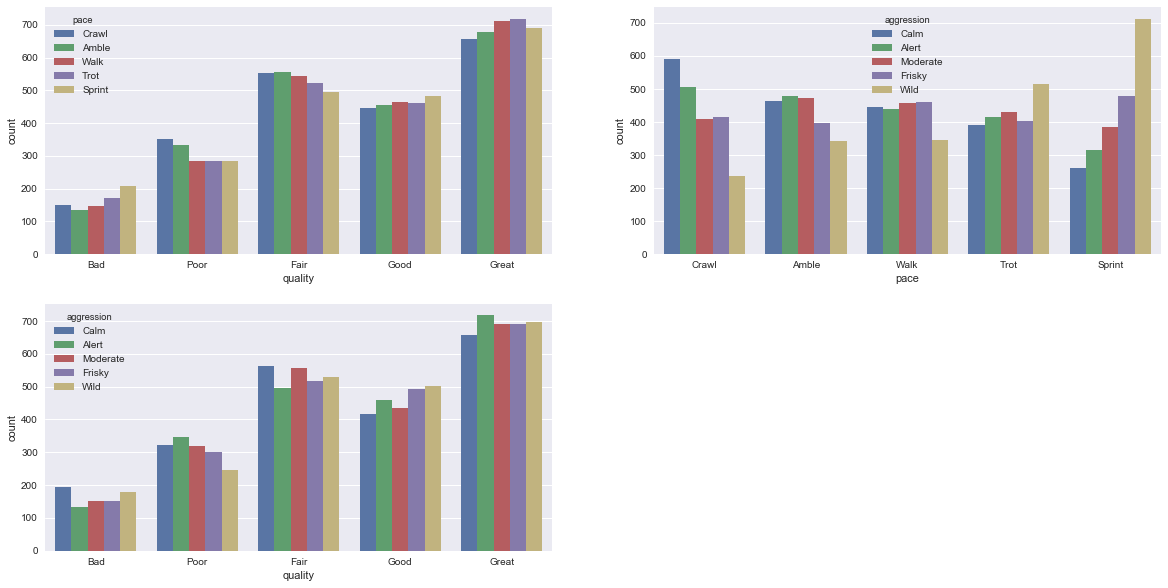

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sns.countplot(x="quality", hue="pace", data=teamDF)

plt.subplot(2,2,2)
ay = sns.countplot(hue="aggression", x="pace", data=teamDF)

plt.subplot(2,2,3)
ay = sns.countplot(hue="aggression", x="quality", data=teamDF)

plt.show()

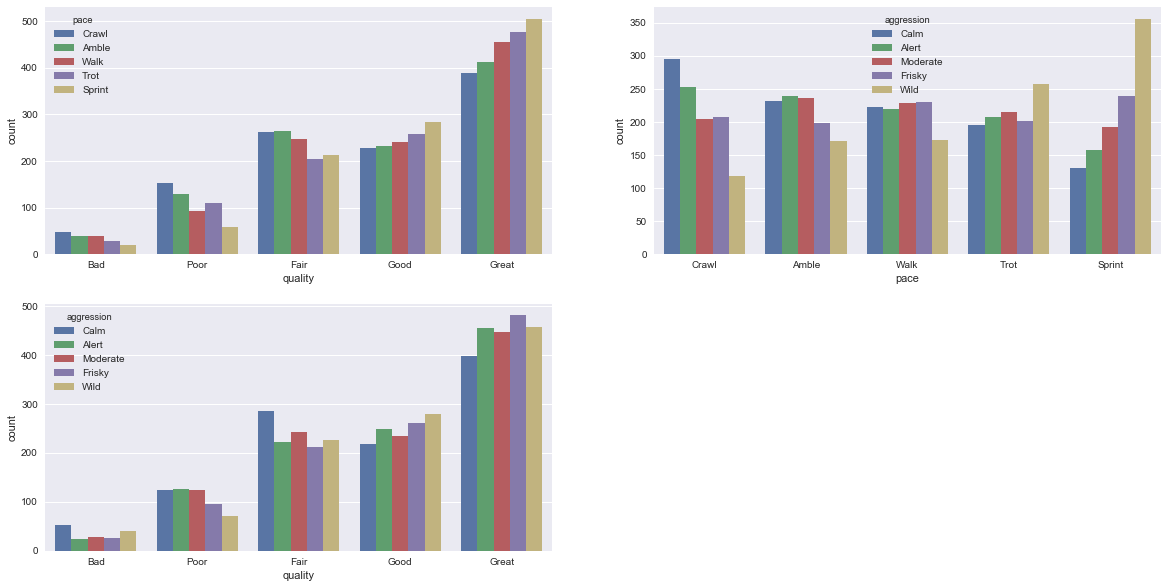

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sns.countplot(x="quality", hue="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,2)
ay = sns.countplot(hue="aggression", x="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,3)
ay = sns.countplot(hue="aggression", x="quality", data=teamDF[teamDF['result'] == 1])

plt.show()

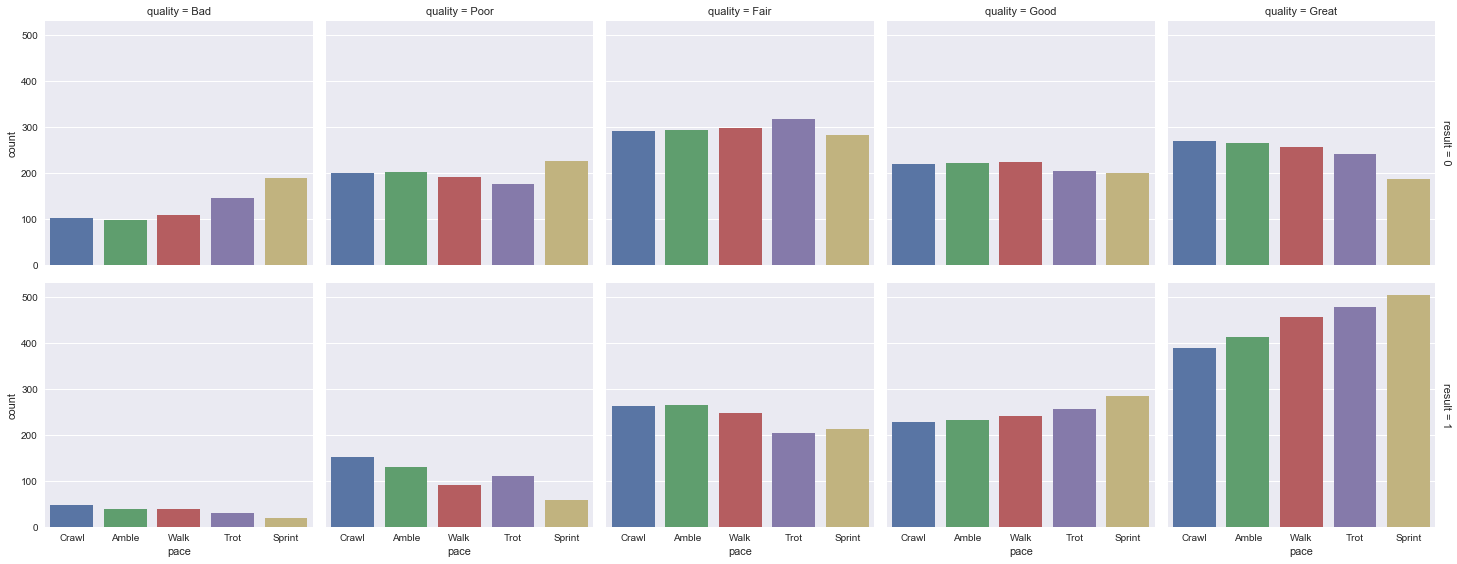

In [39]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="pace", col = 'quality', row = 'result', data=teamDF, kind = 'count', margin_titles = True);

plt.show()

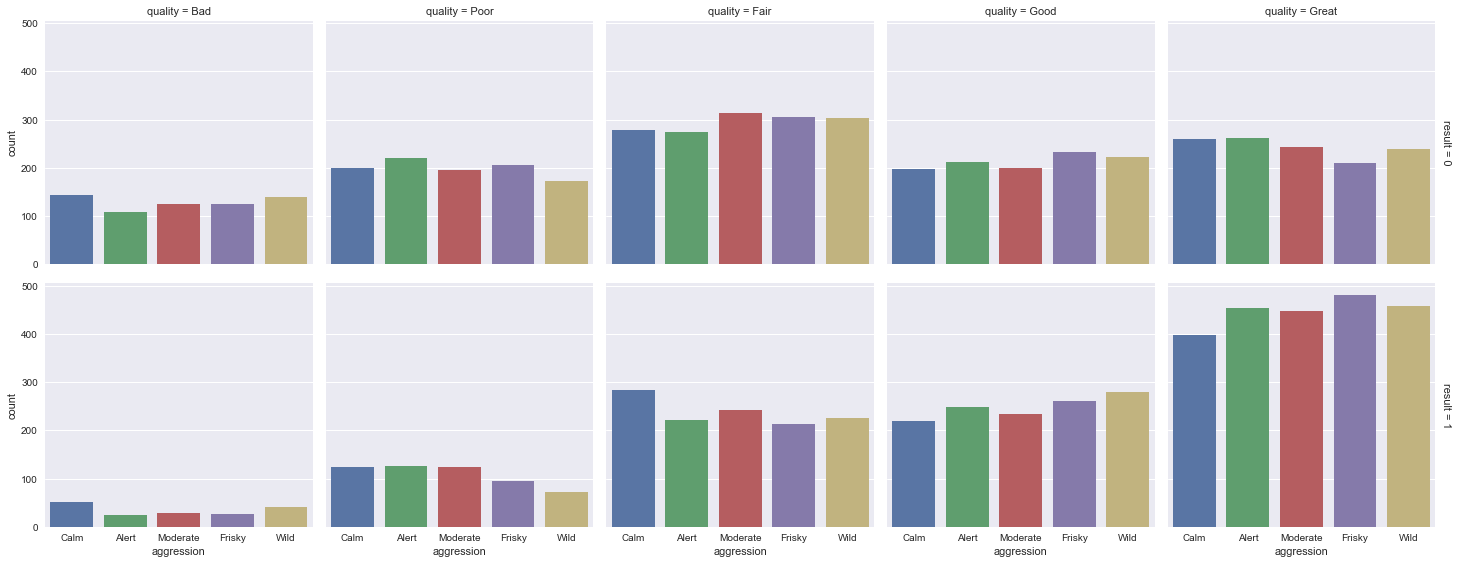

In [40]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="aggression", col = 'quality', row = 'result', data=teamDF, kind = 'count', margin_titles = True);

plt.show()

### Visualizing pace and aggression results for games against 'Great' teams

In [41]:
great_team_games = teamDF[teamDF['quality'] == 'Great']['gameid']

great_teamDF = teamDF[teamDF['gameid'].isin(great_team_games)]

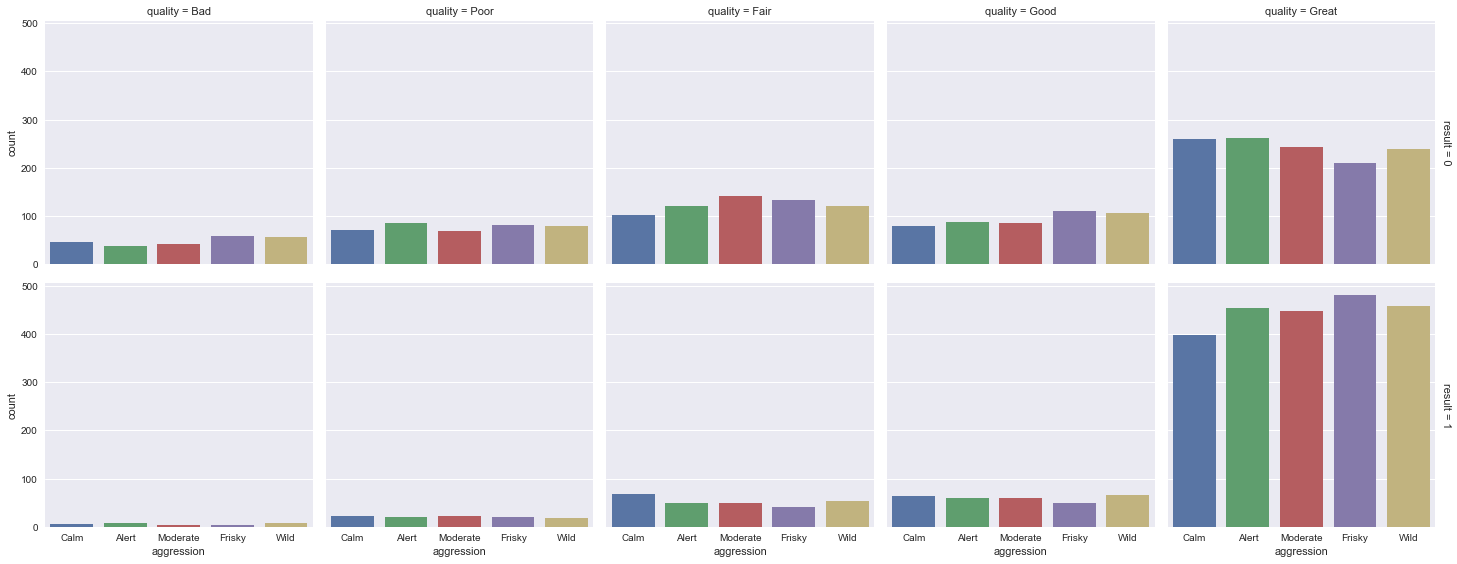

In [42]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="aggression", col = 'quality', row = 'result', data=great_teamDF, kind = 'count', margin_titles = True);
plt.show()

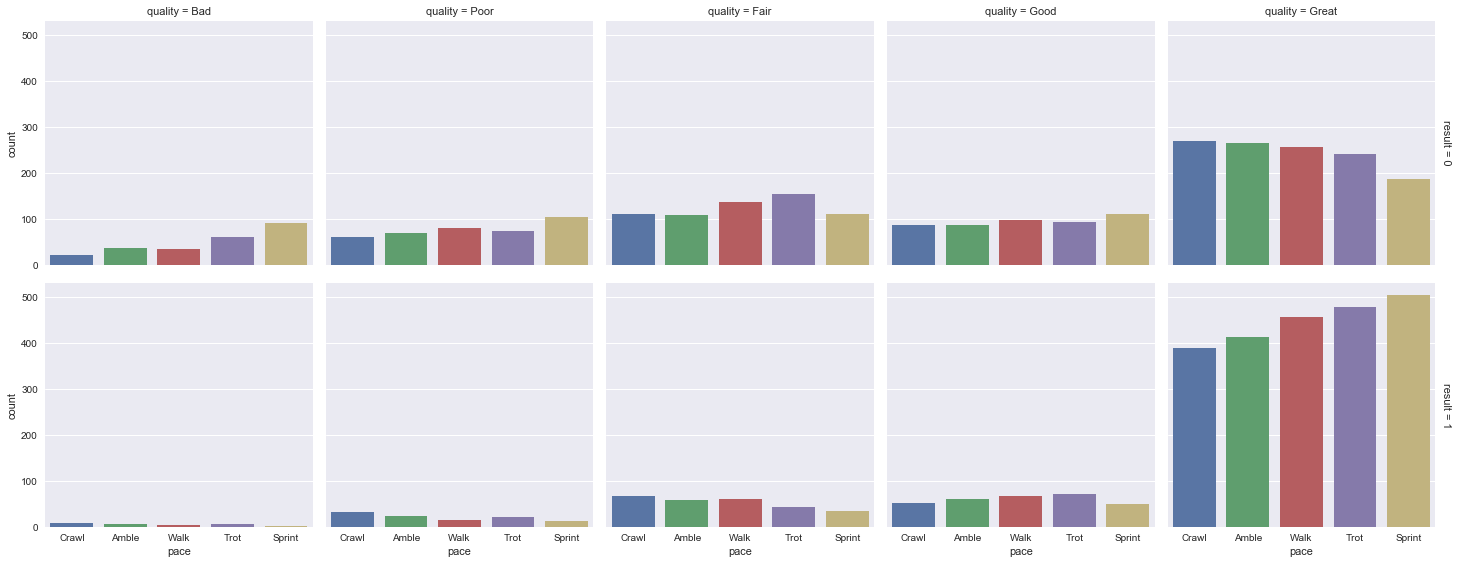

In [43]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="pace", col = 'quality', row = 'result', data=great_teamDF, kind = 'count', margin_titles = True);
plt.show()

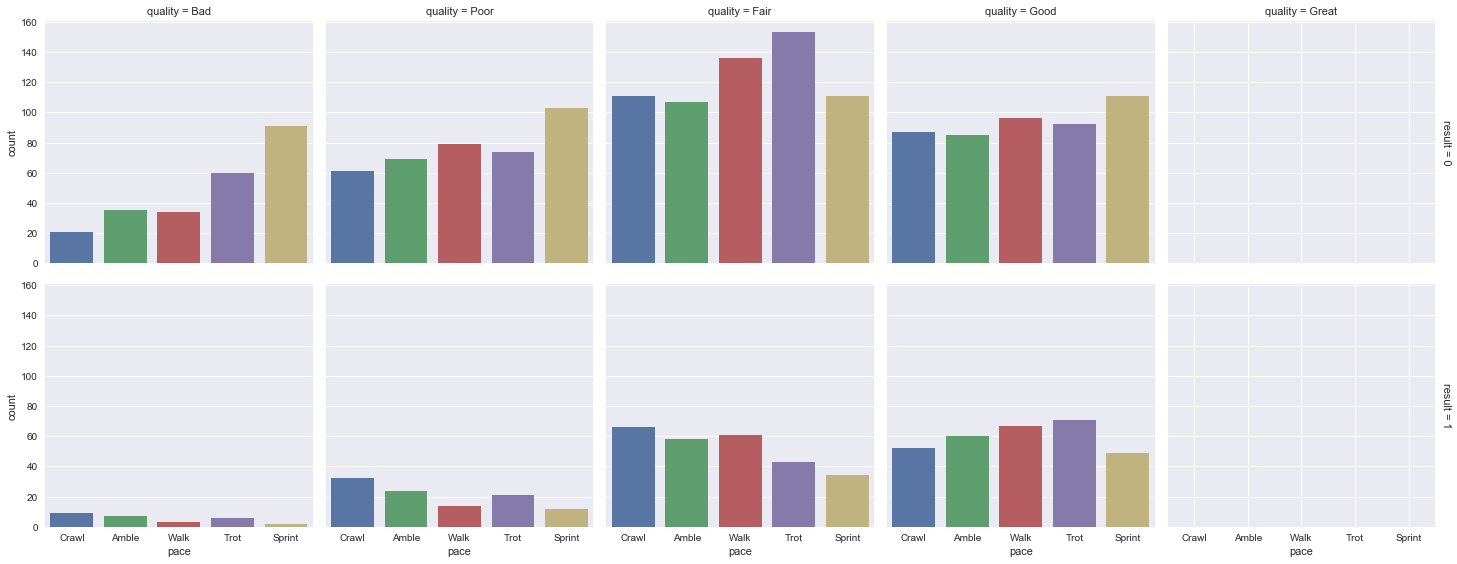

In [44]:
vs_greatDF = great_teamDF[great_teamDF['quality'] != 'Great']

plt.figure(figsize=(20,10))
ay = sns.factorplot( x="pace", col = 'quality', row = 'result', data=vs_greatDF, kind = 'count', margin_titles = True);

plt.show()

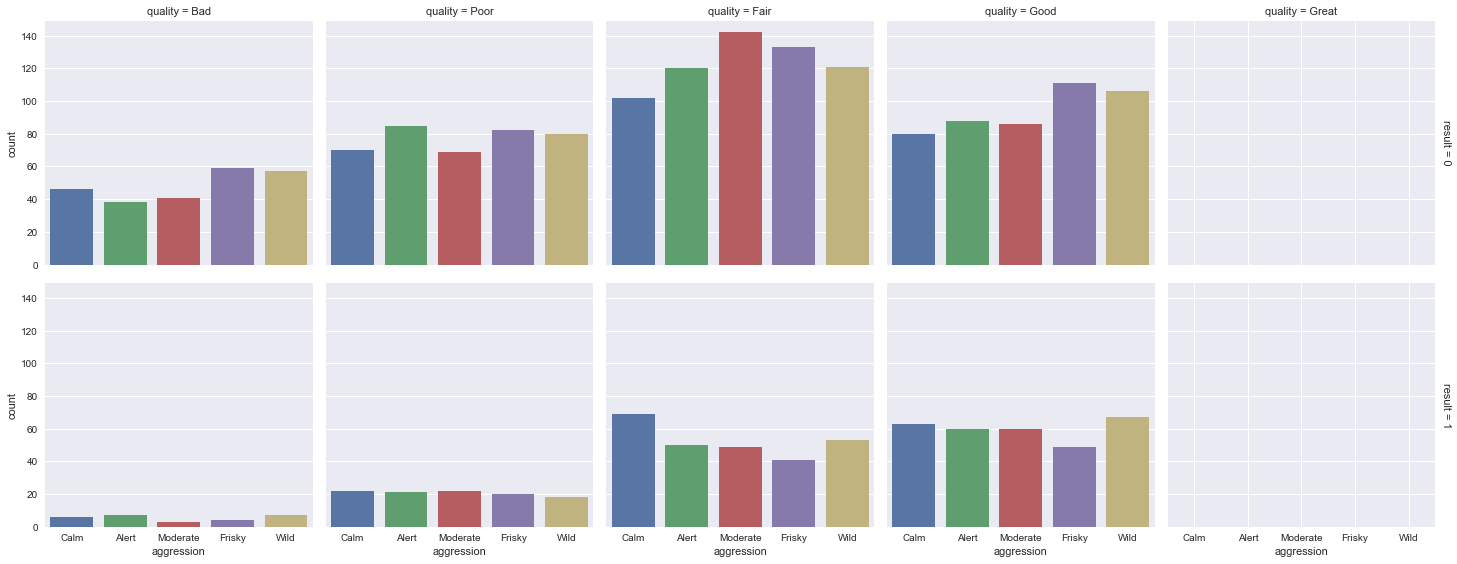

In [45]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="aggression", col = 'quality', row = 'result', data=vs_greatDF, kind = 'count', margin_titles = True);

plt.show()

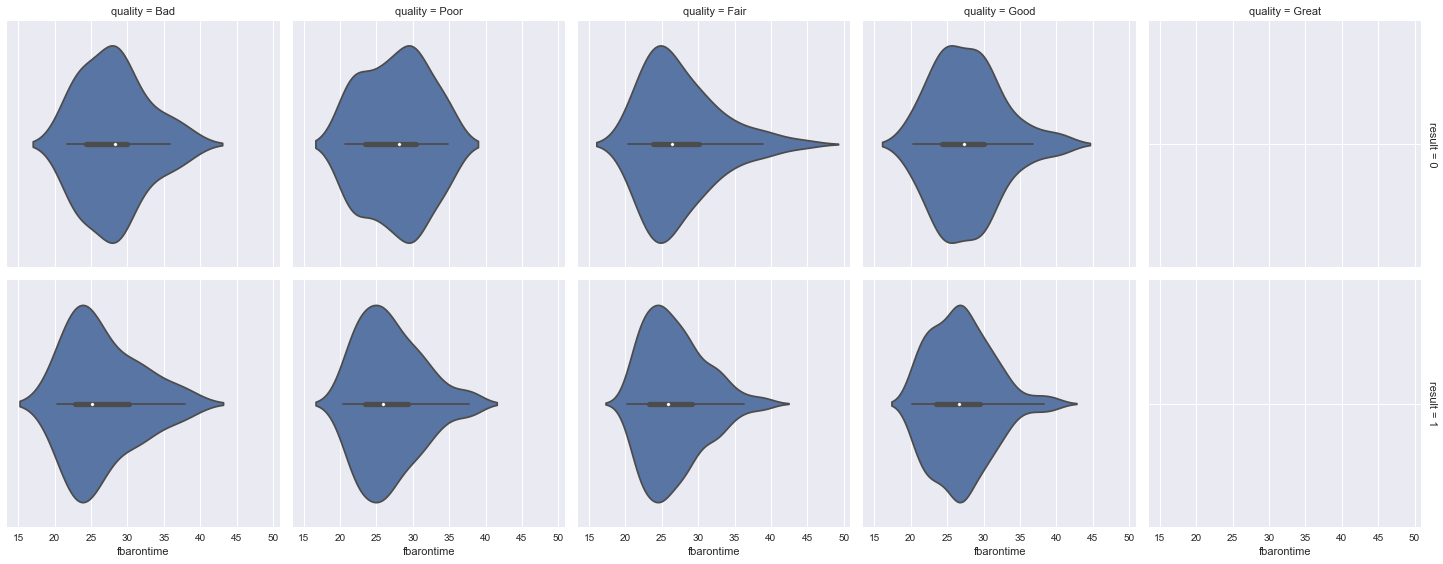

In [46]:
plt.figure(figsize=(20,10))
ay = sns.factorplot( x="fbarontime", col = 'quality', row = 'result', data=vs_greatDF[vs_greatDF.fbaron == 1], kind = 'violin', margin_titles = True);

plt.show()

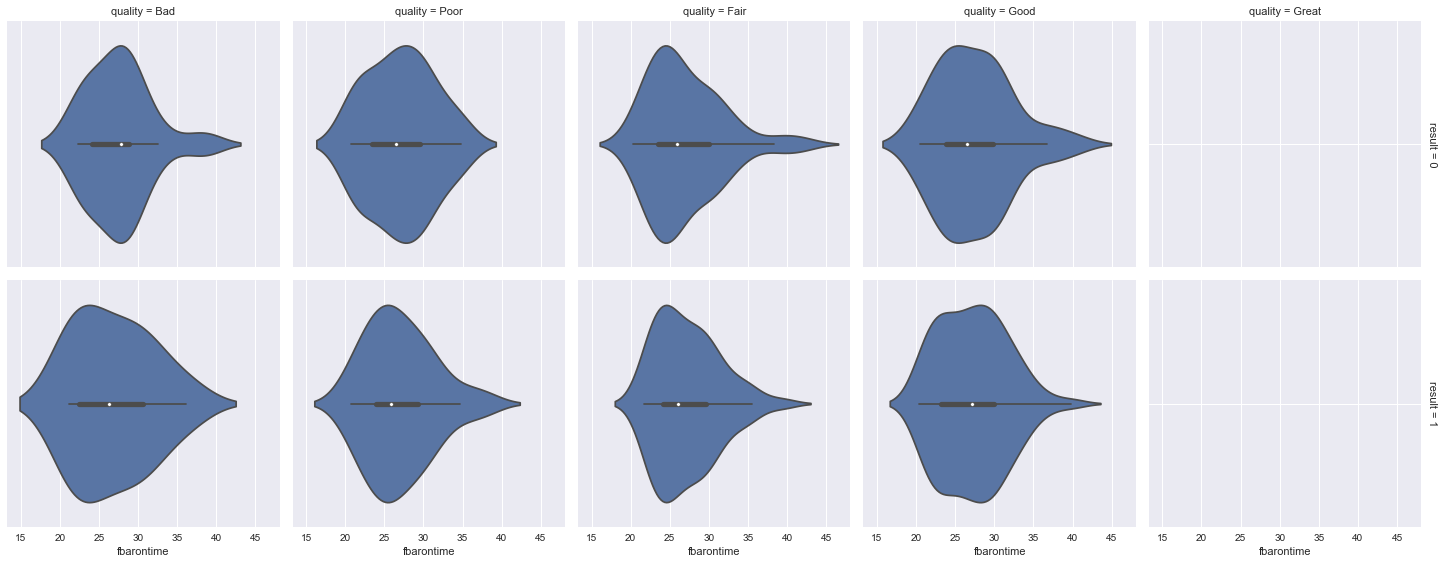

Number of games being plotted:  283


In [47]:
plt.figure(figsize=(20,10))
sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 < 0)
ay = sns.factorplot( x="fbarontime", col = 'quality', row = 'result', data=vs_greatDF[sneak_baron], kind = 'violin', margin_titles = True);

plt.show()
print('Number of games being plotted: ',vs_greatDF[sneak_baron].shape[0])

In [48]:
print('Gold Difference @ 15 mins against great teams: \n', vs_greatDF.gdat15.describe(), '\n')
print('Gold Difference @ 15 mins: \n', teamDF.gdat15.describe(), '\n')

sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 <= -1500)
print('Number of games to plot when trailing by at least 1500 at 15 minutes: ',vs_greatDF[sneak_baron].shape[0], '\n')

sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 <= -2500)
print('Number of games to plot when trailing by at least 2500 at 15 minutes: ',vs_greatDF[sneak_baron].shape[0])

Gold Difference @ 15 mins against great teams: 
 count     2030.000000
mean      -867.642365
std       2540.105373
min     -12081.000000
25%      -2411.500000
50%       -703.000000
75%        755.500000
max       8741.000000
Name: gdat15, dtype: float64 

Gold Difference @ 15 mins: 
 count     9020.000000
mean         0.000000
std       2515.584478
min     -12081.000000
25%      -1576.000000
50%          0.000000
75%       1576.000000
max      12081.000000
Name: gdat15, dtype: float64 

Number of games to plot when trailing by at least 1500 at 15 minutes:  132 

Number of games to plot when trailing by at least 2500 at 15 minutes:  59


In [49]:
sq_list = [[s,q] for s, q in zip(teamDF['side'], teamDF['quality'])]
teamDF['opp_quality'] = [sq_list[i+1][1] if sq_list[i][0] == 'Blue' else sq_list[i-1][1] for i in range(len(sq_list))]
print(teamDF[['team', 'quality', 'side','opp_quality']].head(20))

                  team quality  side opp_quality
10          KT Rolster   Great  Blue        Good
11      Longzhu Gaming    Good   Red       Great
22            ESC Ever    Fair  Blue       Great
23       SK Telecom T1   Great   Red        Fair
34      Afreeca Freecs    Fair  Blue       Great
35          ROX Tigers   Great   Red        Fair
46          KT Rolster   Great  Blue       Great
47       SK Telecom T1   Great   Red       Great
58                INTZ   Great  Blue        Poor
59         g3nerationX    Poor   Red       Great
70     Kongdoo Monster     Bad  Blue       Great
71          KT Rolster   Great   Red         Bad
82   Copenhagen Wolves    Good  Blue        Good
83                Huma    Good   Red        Good
94            CJ Entus    Poor  Blue       Great
95       SK Telecom T1   Great   Red        Poor
106      SK Telecom T1   Great  Blue        Poor
107           CJ Entus    Poor   Red       Great
118     Afreeca Freecs    Fair  Blue       Great
119         KT Rolst

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
# ---------- First Blood by Side -----------------

    #------------ Games involving great teams --------
fb_great = great_teamDF[['fb']].groupby(great_teamDF['side']).mean()
print('------------ Games involving great teams --------')
print(fb_great)

blue = great_teamDF[great_teamDF['side'] == 'Blue']['fb']
red = great_teamDF[great_teamDF['side'] == 'Red']['fb']
print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

    # ------------------- Lesser teams vs great teams -------
fb_vgreat = vs_greatDF[['fb']].groupby(vs_greatDF['side']).mean()
print('\n------------------- Lesser teams vs great teams -------')
print(fb_vgreat)

blue = vs_greatDF[vs_greatDF['side'] == 'Blue']['fb']
red = vs_greatDF[vs_greatDF['side'] == 'Red']['fb']
print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

# -----------Result by Side-------------

    #------------ Games involving great teams --------
great_side = great_teamDF[['result']].groupby(great_teamDF['side']).mean()
print('\n------------ Games involving great teams --------')
print(great_side)

blue = great_teamDF[great_teamDF['side'] == 'Blue']['result']
red = great_teamDF[great_teamDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))

    # ------------------- Lesser teams vs great teams -------
vgreat_side = vs_greatDF[['result']].groupby(vs_greatDF['side']).mean()
print('\n------------------- Lesser teams vs great teams -------')
print(vgreat_side)

blue = vs_greatDF[vs_greatDF['side'] == 'Blue']['result']
red = vs_greatDF[vs_greatDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))


------------ Games involving great teams --------
            fb
side          
Blue  0.527455
Red   0.472545
Ttest_indResult(statistic=3.8839081135227, pvalue=0.00010412113194965158)

------------------- Lesser teams vs great teams -------
            fb
side          
Blue  0.499497
Red   0.437681
Ttest_indResult(statistic=2.794342811134642, pvalue=0.0052494413095834063)

------------ Games involving great teams --------
        result
side          
Blue  0.547253
Red   0.452747
Ttest_indResult(statistic=7.2670966800777945, pvalue=4.1525384047472068e-13)

------------------- Lesser teams vs great teams -------
        result
side          
Blue  0.333616
Red   0.242474
Ttest_indResult(statistic=4.9641423074258109, pvalue=7.3839952966919455e-07)


In [51]:
opp_group = teamDF[['result', 'fb']].groupby(teamDF['opp_quality']).mean()
print(opp_group)

               result        fb
opp_quality                    
Bad          0.785978  0.579292
Fair         0.553558  0.500000
Good         0.461872  0.476483
Great        0.351664  0.478041
Poor         0.646484  0.541427


In [52]:
teamDF['opp_quality'] = teamDF['opp_quality'].astype('category')
teamDF['opp_quality'].cat.reorder_categories(['Bad', 'Poor', 'Fair', 'Good', 'Great'], ordered=True, inplace = True)
qual_group = teamDF[['result', 'fb','opp_quality','quality']].groupby(['opp_quality', 'quality']).mean()
print(qual_group)

                       result        fb
opp_quality quality                    
Bad         Bad      0.500000  0.500000
            Poor     0.643478  0.574257
            Fair     0.767196  0.600000
            Good     0.838150  0.564417
            Great    0.908397  0.600000
Poor        Bad      0.356522  0.425743
            Poor     0.500000  0.500000
            Fair     0.612195  0.560127
            Good     0.661972  0.547619
            Great    0.793617  0.566845
Fair        Bad      0.232804  0.400000
            Poor     0.387805  0.439873
            Fair     0.500000  0.500000
            Good     0.605536  0.547253
            Great    0.707800  0.521307
Good        Bad      0.161850  0.435583
            Poor     0.338028  0.452381
            Fair     0.394464  0.452747
            Good     0.500000  0.500000
            Great    0.619624  0.500000
Great       Bad      0.091603  0.400000
            Poor     0.206383  0.433155
            Fair     0.292200  0.478693


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


NOTES:
- 2 ways to perform feature selection
- see which features are most important, build model that incorporates these important features and removes/discards non-important ones
- feature engineering/feature selection 'Introduction to feature selection'
- now is a matter of seeing which observations are valid and which are noise (through si testing and simple models)
- look into stats.models has richer models around general models - api more robust

In [53]:
# teamDF.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\teamDF-Oct9.csv')

# Model Building

Now that we've explored the grouped team data, it's time to start building some logistic regressions using the 'result' column as our binary outcome variable.

First, we'll attempt this regression on all features to get a baseline for how well the data can predict the outcome without any transformations. We'll start by importing the sklearn modules that will be used for performing and evaluating the logistic regression.

In [54]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Splitting The Data

We'll split the teamDF dataframe into 4 sub-dataframes - first into predictors and the outcome, then into training and testing sets, preserving the original indexing.

In [56]:
reg_teamDF = teamDF.copy()
regressors = list(set(list(reg_teamDF)) - set(['result']))
X = reg_teamDF.loc[:, regressors].values
y = reg_teamDF.loc[:,'result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=10)

### Fitting The Model

Next, we'll fit the logistic regression model.

In [57]:
try:
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
except Exception as ex:
    print(ex)

could not convert string to float: 'Red'


Because there are NaN's in our inputs, LogisticRegression is unable to perform a fit on our training data. We'll need a method for handling this.

### Handling Missing Data

First, we know from earlier calls to .info() that there's a few columns in teamDF that are all NaN (these are all columns that have values in playerDF but not in teamDF). We won't be needing any of these columns. All of this and the following NaN transformations will be done on a duplicate dataframe.

In [58]:
print('Columns with all NaN values --', teamDF.columns[teamDF.isnull().all()].tolist())

reg_teamDF = teamDF.copy()
reg_teamDF.dropna(axis = 'columns', how = 'all', inplace = True)
print('Columns with all NaN values --', reg_teamDF.columns[reg_teamDF.isnull().all()].tolist())

Columns with all NaN values -- ['doubles', 'triples', 'quadras', 'pentas', 'dmgshare', 'earnedgoldshare']
Columns with all NaN values -- []


That takes care of entirely NaN columns, but we still have to deal with coolumns containing some NaN values. We can either completely drop columns containing NaN's or impute missing values. Since so many columns have at least a few missing values, there would be very few predictors remaining if we went with the former, so we'll go with imputing.

We'd like to impute either by median values or mean values. Mean is preferrable to median, provided the mean is not being influenced by a large number of very large outliers.

**Assumption - Note:** *very large outliers* in this case will be refer to observations more than three standard deviations from the mean, while *large number* will mean at least 1% of observations.

In [59]:
null_cols = reg_teamDF._get_numeric_data().columns[reg_teamDF._get_numeric_data().isnull().any()].tolist()
mean = reg_teamDF[null_cols].mean()
sd = reg_teamDF[null_cols].std()

outliers = {c:{'mean':mean[c], 'sd':sd[c],
               'values':[v for v in reg_teamDF[c] if abs(v - mean[c]) > 3*sd[c]]} for c in null_cols}

for k in outliers.keys():
    if len(outliers[k]['values']) >= 100:
        print('Feature: ', k)
        print('Mean: {} and St Dev: {}, Outlier Count: {}'.format(outliers[k]['mean'],
                                                                  outliers[k]['sd'], len(outliers[k]['values'])), '\n')

Feature:  date
Mean: 39655.90773846363 and St Dev: 11001.897307010122, Outlier Count: 694 

Feature:  fbtime
Mean: 6.559774005912805 and St Dev: 3.852554686429645, Outlier Count: 128 

Feature:  dmgtochamps
Mean: 72155.69578713969 and St Dev: 29205.11791982077, Outlier Count: 122 

Feature:  wardkills
Mean: 50.67151744056876 and St Dev: 21.10930304233139, Outlier Count: 110 

Feature:  visionwards
Mean: 31.480949041608227 and St Dev: 14.538736402749127, Outlier Count: 146 

Feature:  goldspent
Mean: 59821.31729490022 and St Dev: 15237.27190880845, Outlier Count: 101 



Okay, all of those features look like reasonable choices for median imputation. All the other features containing NaN's will be corrected with mean imputation.

In [60]:
median_cols = [o for o in outliers.keys() if len(outliers[o]['values']) >= 100]
mean_cols = list(set(null_cols) - set(median_cols))

reg_teamDF[mean_cols] = reg_teamDF[mean_cols].fillna(reg_teamDF.mean())
reg_teamDF[median_cols] = reg_teamDF[median_cols].fillna(reg_teamDF.median())

if not reg_teamDF.isnull().values.any():
    print("NaN's successfully imputed")
else:
    print("NaN's remain in: ", reg_teamDF.columns[reg_teamDF.isnull().any()].tolist())

NaN's remain in:  ['url', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'aggression']


Since we still have NaN's in the non-numeric columns, let's see how serious a problem it is.

In [61]:
reg_teamDF.isnull().sum().sort_values(ascending = False)[:7]/len(reg_teamDF)

ban5          0.448062
ban4          0.445465
url           0.163606
ban1          0.002875
ban3          0.002690
ban2          0.001020
aggression    0.000742
dtype: float64

Okay, there are very few observations with missing data in features 'ban1', 'ban2', 'ban3', and 'aggression' - so it shouldn't effect the regression too strongly if we outright drop those observations.

'url' refers to the url where the complete match data for each observation is being stored, so while this feature may be useful for adding more features to the dataset at some point, it has no benefit as a regressor and can be dropped.

In [62]:
reg_teamDF.dropna(axis='rows',subset=['ban1','ban2','ban3','aggression'], how = 'any', inplace=True)
reg_teamDF.drop(['url'], axis='columns', errors = 'ignore', inplace= True)

The same things cannot be said for 'ban4' and 'ban5', which have missing data in nearly half their observations. This is because a 4th and 5th in the champion selection stage of matches was only added to the game in the last year. There are several ways to handle this issue. We could split the dataframe into observations that have values for those features and observations that don't, and then perform seperate regressions on each. We could impute the median entry of each column (since they are both categorical data). Or, we could drop the features.

For this baseline regression, we'll go ahead and drop the features, but we'll revisit this problem as we fine-tune our model later on.

In [63]:
reg_teamDF.drop(['ban4','ban5'], axis='columns', errors = 'ignore', inplace= True)

if not reg_teamDF.isnull().values.any():
    print("NaN's successfully imputed")
else:
    print("NaN's remain in: ", reg_teamDF.columns[reg_teamDF.isnull().any()].tolist())

NaN's successfully imputed


### Fitting The Model (Again!)

Now that all the NaN's have been imputed or dropped, let's re-attempt our logistic regression.

In [64]:
regressors = list(set(list(reg_teamDF)) - set(['result']))
X = reg_teamDF.loc[:, regressors].values
y = reg_teamDF.loc[:,'result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=10)

try:
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
except Exception as ex:
    print(ex)

could not convert string to float: 'Blue'


In addition to NaN's, a logistic regression is also flustered by non-numeric features. For categorical features, we can handle this by created dummy variables (which we'll get to later). For less meaningful features - like team names, we can drop them from the regression.

In [65]:
non_nums = list(reg_teamDF.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']))
print(non_nums)
print(type(non_nums))

['gameid', 'league', 'split', 'week', 'game', 'patchno', 'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'quality', 'pace', 'aggression', 'opp_quality']
<class 'list'>


First, let's attempt a regression only on the numeric columns, then we'll expand to include the categorical ones.

### Fitting The Model (Again, again)

We'll fit a model using only the numeric features of reg_teamDF

In [66]:
regressors = list(set(list(reg_teamDF)) - set(non_nums) - set(['result']))
X = reg_teamDF.loc[:, regressors].values
y = reg_teamDF.loc[:,'result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=10)

try:
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
except Exception as ex:
    print(ex)

### Evaluating the regression

Success! Now we'll see how well this basic logistic regression on the numeric columns worked as a classifier.

In [67]:
confusion_matrix = confusion_matrix(y_test, pred)
confusion_matrix

array([[1348,   16],
       [  23, 1294]])

That worked remarkably well. Suspiciously well actually. The confusion matrix says we correctly predicted 1348 losses as losses, and 1294 wins as wins. Let's look at the classification report as well.

In [68]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1364
          1       0.99      0.98      0.99      1317

avg / total       0.99      0.99      0.99      2681



## Tuning the regression
***

The model was extremely successful in predicting wins and losses. However, it was provided with features that contained a mix of in-game and pre-game information. Since the goal of this analysis is to determine pre-game strategies teams can apply to increase their chances of winning, we'd like to make the model as independent of in-game information as possible.

Let's start by looking at the coefficients our model produced, and seeing which features had the strongest effect.

In [103]:
cfs = sorted(list(zip(lr.coef_[0], regressors)))
print("Strongest negative effects: ", *cfs[:10], sep ='\n')
print("\n Strongest positive effects: ", *cfs[-10:][::-1], sep='\n')

Strongest negative effects: 
(-0.66931419759105637, 'opptowerkills')
(-0.16104913974775251, 'gamelength')
(-0.1435244897245736, 'cspm')
(-0.11474658547703745, 'd')
(-0.11474658547703745, 'teamdeaths')
(-0.044145857595901346, 'oppdragkills')
(-0.023262376361339872, 'oppelementals')
(-0.021080678926604583, 'oppbaronkills')
(-0.020506763494470448, 'wpm')
(-0.014549505567118775, 'fdtime')

 Strongest positive effects: 
(0.56865153607190344, 'teamtowerkills')
(0.045068380266909708, 'a')
(0.033136257858742899, 'teamkills')
(0.033136257858742899, 'k')
(0.033110621435705825, 'elementals')
(0.031951266522651706, 'teamdragkills')
(0.023003349751880391, 'visionwards')
(0.019448053021457603, 'oppelders')
(0.016993247633173919, 'monsterkillsownjungle')
(0.016967567848715413, 'fbarontime')


We should examine the more easily interpretable odds ratios of the coefficients. Note that each of these odds ratios represents the change in probability of a win for a 1 unit increase in its respective predictor with all other predictors held constant.

In [130]:
ecfs = sorted(zip(np.exp(lr.coef_[0]) - [1]*len(lr.coef_[0]), regressors))
print("Strongest negative effects: ", *ecfs[:10], sep ='\n')
print("\n Strongest positive effects: ", *ecfs[-10:][::-1], sep='\n')
print("\n Intercept: ", np.exp(lr.intercept_[0]))

Strongest negative effects: 
(-0.48794037087596698, 'opptowerkills')
(-0.14874976014268981, 'gamelength')
(-0.13370041551075995, 'cspm')
(-0.10840794234332196, 'd')
(-0.10840794234332196, 'teamdeaths')
(-0.043185611351744591, 'oppdragkills')
(-0.022993893166194268, 'oppelementals')
(-0.020860034578686681, 'oppbaronkills')
(-0.02029792975742517, 'wpm')
(-0.014444172975482283, 'fdtime')

 Strongest positive effects: 
(0.76588421404583751, 'teamtowerkills')
(0.046099390018568664, 'a')
(0.033691378219675938, 'teamkills')
(0.033691378219675938, 'k')
(0.033664878409895849, 'elementals')
(0.032467188362731658, 'teamdragkills')
(0.023269967241973388, 'visionwards')
(0.019638398350893205, 'oppelders')
(0.017138454210096965, 'monsterkillsownjungle')
(0.017112334649202143, 'fbarontime')

 Intercept:  0.99947259893


**Quick Insights:**
***
- Tower kills are the strongest determinants (and we observed this correlation earlier in the analysis).
- A death is more damaging than a kill is beneficial, so 'trade' kills are not recommended.
- Gamelength should not have any effect, because there should be an equal number of wins and losses with each game length. Something strange is going on, likely with rows that were dropped with missing values.
- The negative effect of 'cspm' is also surprising. Why would teams that are more efficiently farming gold be less likely to win? Something strange is going on here.

Before addressing the problem of feature selection for a pre-game focused regression, let's take a quick detour to see what's going on with 'gamelength' and 'cspm' in the model.

**Correlations of cspm & gamelength to result:**

Let's check if the coefficients for cspm and gamelength in the regression can be validated by their correlations to result. Remembering that we stored the correlation matrix as `corr` earlier on:

In [85]:
corr.result[['cspm', 'gamelength']]

cspm          0.26258
gamelength    0.00000
Name: result, dtype: float64

As should be expected, gamelength has absolutely no correlation with result, while cspm has a weak-to-moderate **positive** correlation.

**Means of cspm & gamelength grouped by result:**

We can also examine the mean values for each of these features when grouped by result.

In [88]:
teamDF[['cspm', 'gamelength']].groupby(teamDF['result']).mean()

,cspm,gamelength
result,,
0,30.029181,36.314276
1,31.331264,36.314276


Again as expected, gamelength has an identical mean for wins and losses, while cspm is **higher** for wins than losses.

**Interpretation**

There are two possibilities to consider:

1. The regression was influenced by the rows containing NaN's that were removed from reg_teamDF. In such a case, if a disproportionate number of losses with short game lengths and/or wins with long game lengths were removed, the model would unfairly believe that longer games meant a greater liklihood of defeat. And the same thinking applies with cspm.

2. The model is using gamelength and cspm to correct against the coefficient of another predictor.

The first possibility is fairly simple to test by applying the same evaluations to reg_teamDF as we did to teamDF.

In [89]:
reg_teamDF[['cspm', 'gamelength']].groupby(reg_teamDF['result']).mean()

,cspm,gamelength
result,,
0,30.139954,36.336990
1,31.224691,36.345179


In [90]:
reg_teamDF.corr().result[['cspm', 'gamelength']]

cspm          0.239161
gamelength    0.000519
Name: result, dtype: float64

Interestingly enough, the modified dataframe the model was built from not only has similar correlation between cspm and result, but the correlation between gamelength and result is also positive (albeit negligably so). This suggests that the dropped rows are not the culprit of these coefficients, but rather a relationship between the predictors.

Something is happening where the the coefficients for gamelength and cspm are being constructed as negative to counteract the effects of the other predictors. With gamelength, this is more easily interpretable because so many of the model's predictors typically have higher observed values in longer games (kills, deaths, gold earned, etc).

It is not as clear why cspm, a rate of time value, is also being used as a balancing mechanism. My theory is that this is an indicator of a lack of independence among the predictors, and the correlation matrix heatmap generated earlier can confirm this. What is not able to be confirmed or rejected from that heatmap though is the presence of multicolinearity among the predictors (instances where the predictor can be interpretted as a dependent variable for a subset of the predictors). This will be investigated later on.

### Logistic Regression w/ Categoricals

Before we get into feature selection to tune the model, we'd first like to examine a model that includes as predictors the categorical features that were dropped earlier on.

In [142]:
print(teamDF.describe(include = ['category']))

       league   split   week   game   patchno  playerid   side position  \
count   10782   10782  10782  10782  10782.00     10782  10782    10782   
unique     21      14     99     31     34.00         2      2        1   
top       LCK  2017-2     SF      2      7.04       200    Red     Team   
freq     1928    2538    448   3738    550.00      5391   5391    10782   

       player           team champion     ban1     ban2   ban3    ban4  \
count   10782          10782    10782    10751    10771  10753    5979   
unique      1            161        1      107      113    116     111   
top      Team  SK Telecom T1           LeBlanc  LeBlanc   Ryze  Syndra   
freq    10782            261    10782      659      474    476     297   

          ban5 quality    pace aggression opp_quality  
count     5951   10782   10782      10774       10782  
unique     115       5       5          5           5  
top     Syndra   Great  Sprint     Frisky       Great  
freq       308    3455    216

There are 21 categorical variables. Some of these won't be needed (like player which is 'Team' for all entries and champion which is empty for all). However, some columns are also going to need to be added. Because the rows taken from the original dataframe to form teamDF don't have any champion specific data, and we're ultimately trying to build a model that relies exclusively on pre-game decisions, we're going to need the five champion selections as additional columns.

**NOTE:** Bans and champion selections have fairly high cardinality (each of the 8-10 features has over 100 values). This means that adding dummy variables to represent all of these possible choices in the regression will add over 1000 columns to the dataframe. This may exceed the memory limits of the machine performing this analysis.

## Work/Struggle In Progress

So, I'm running into something that I can't seem to figure out. Spent a couple hours searching for and attempting solutions, but I can't figure out how to pivot the champion selections out of playerDF and concat to teamDF without creating duplicate indexes to handle columns with missing values. In other words, and as you'll see in the sub-slides, pivotting from playerDF on the position column with champion values gives a dataframe that has only one valid entry per row (the champion corresponding to the position value at that index in the original dataframe). I can't figure out how to collapse those rows. At least not elegantly. I can think of brute force techniques (writing a custom function for fillna that will fill all entries of a gameid/team combination in a column with the only valid entry found and then dropping duplicate rows from final df) but I know there has to be a simple way to do this that I can't seem to suss out.

In [154]:
test = teamDF.copy()
test.set_index(['gameid', 'team'], inplace = True)
test.sort_index(inplace = True)
test.head(20)

url  \
gameid  team                                                                     
1000029 Jin Air Green Wings  http://matchhistory.na.leagueoflegends.com/en/...   
        SBENU Sonicboom      http://matchhistory.na.leagueoflegends.com/en/...   
1000116 CJ Entus             http://matchhistory.na.leagueoflegends.com/en/...   
        SBENU Sonicboom      http://matchhistory.na.leagueoflegends.com/en/...   
1000306 Kongdoo Monster      http://matchhistory.na.leagueoflegends.com/en/...   
        Longzhu Gaming       http://matchhistory.na.leagueoflegends.com/en/...   
1000316 Kongdoo Monster      http://matchhistory.na.leagueoflegends.com/en/...   
        Longzhu Gaming       http://matchhistory.na.leagueoflegends.com/en/...   
1000320 Jin Air Green Wings  http://matchhistory.na.leagueoflegends.com/en/...   
        KT Rolster           http://matchhistory.na.leagueoflegends.com/en/...   
1000331 Jin Air Green Wings  http://matchhistory.na.leagueoflegends.com/en/...   
        KT Rolster           http://matchhistory.na.leagueoflegends.com/en/...   
1000453 Afreeca Freecs       http://matchhistory.na.leagueoflegends.com/en/...   
        SK Telecom T1        http://matchhistory.na.leagueoflegends.com/en/...   
1000462 Jin Air Green Wings  http://matchhistory.na.leagueoflegends.com/en/...   
        Kongdoo Monster      http://matchhistory.na.leagueoflegends.com/en/...   
1000469 Jin Air Green Wings  http://matchhistory.na.leagueoflegends.com/en/...   
        Kongdoo Monster      http://matchhistory.na.leagueoflegends.com/en/...   
1000512 ROX Tigers           http://matchhistory.na.leagueoflegends.com/en/...   
        Samsung Galaxy       http://matchhistory.na.leagueoflegends.com/en/...   

                            league   split          date week game patchno  \
gameid  team                                                                 
1000029 Jin Air Green Wings    LCK  2016-1  42431.125278  8.1    1    6.04   
        SBENU Sonicboom        LCK  2016-1  42431.125278  8.1    1    6.04   
1000116 CJ Entus               LCK  2016-1  42433.124398  8.3    1    6.04   
        SBENU Sonicboom        LCK  2016-1  42433.124398  8.3    1    6.04   
1000306 Kongdoo Monster        LCK  2016-1  42438.124271  9.1    1    6.04   
        Longzhu Gaming         LCK  2016-1  42438.124271  9.1    1    6.04   
1000316 Kongdoo Monster        LCK  2016-1  42438.167106  9.1    2    6.04   
        Longzhu Gaming         LCK  2016-1  42438.167106  9.1    2    6.04   
1000320 Jin Air Green Wings    LCK  2016-1  42438.208461  9.1    1    6.04   
        KT Rolster             LCK  2016-1  42438.208461  9.1    1    6.04   
1000331 Jin Air Green Wings    LCK  2016-1  42438.252245  9.1    2    6.04   
        KT Rolster             LCK  2016-1  42438.252245  9.1    2    6.04   
1000453 Afreeca Freecs         LCK  2016-1  42440.205023  9.3    3    6.04   
        SK Telecom T1          LCK  2016-1  42440.205023  9.3    3    6.04   
1000462 Jin Air Green Wings    LCK  2016-1  42440.244560  9.3    1    6.04   
        Kongdoo Monster        LCK  2016-1  42440.244560  9.3    1    6.04   
1000469 Jin Air Green Wings    LCK  2016-1  42440.290810  9.3    2    6.04   
        Kongdoo Monster        LCK  2016-1  42440.290810  9.3    2    6.04   
1000512 ROX Tigers             LCK  2016-1  42441.220880  9.4    1    6.04   
        Samsung Galaxy         LCK  2016-1  42441.220880  9.4    1    6.04   

                            playerid  side position     ...       gdat15  \
gameid  team                                            ...                
1000029 Jin Air Green Wings      200   Red     Team     ...       1255.0   
        SBENU Sonicboom          100  Blue     Team     ...      -1255.0   
1000116 CJ Entus                 100  Blue     Team     ...       2245.0   
        SBENU Sonicboom          200   Red     Team     ...      -2245.0   
1000306 Kongdoo Monster          200   Red     Team     ...      -1855.0   
        Longzhu Gamin

In [220]:
temp = playerDF.copy()
temp = temp.set_index(['gameid', 'team'])
temp.sort_index(inplace=True)
test = pd.concat([playerDF[['gameid', 'team']], playerDF.pivot(columns = 'position', values = 'champion')], axis = 'columns')
print(playerDF[['gameid','team','position','champion']].head(20))
test.head(20)

     gameid            team position    champion
0   1160150      KT Rolster      Top        Gnar
1   1160150      KT Rolster   Jungle      Gragas
2   1160150      KT Rolster   Middle       Varus
3   1160150      KT Rolster      ADC     Kog'Maw
4   1160150      KT Rolster  Support     Alistar
5   1160150  Longzhu Gaming      Top       Yasuo
6   1160150  Longzhu Gaming   Jungle     Hecarim
7   1160150  Longzhu Gaming   Middle      Viktor
8   1160150  Longzhu Gaming      ADC       Sivir
9   1160150  Longzhu Gaming  Support  Tahm Kench
12  1160184        ESC Ever      Top   Gangplank
13  1160184        ESC Ever   Jungle       Elise
14  1160184        ESC Ever   Middle       Karma
15  1160184        ESC Ever      ADC        Jhin
16  1160184        ESC Ever  Support       Janna
17  1160184   SK Telecom T1      Top        Gnar
18  1160184   SK Telecom T1   Jungle     Hecarim
19  1160184   SK Telecom T1   Middle     Taliyah
20  1160184   SK Telecom T1      ADC        Ashe
21  1160184   SK Tel

,gameid,team,ADC,Jungle,Middle,Support,Top
0,1160150,KT Rolster,NaN,NaN,NaN,NaN,Gnar
1,1160150,KT Rolster,NaN,Gragas,NaN,NaN,NaN
2,1160150,KT Rolster,NaN,NaN,Varus,NaN,NaN
3,1160150,KT Rolster,Kog'Maw,NaN,NaN,NaN,NaN
4,1160150,KT Rolster,NaN,NaN,NaN,Alistar,NaN
5,1160150,Longzhu Gaming,NaN,NaN,NaN,NaN,Yasuo
6,1160150,Longzhu Gaming,NaN,Hecarim,NaN,NaN,NaN
7,1160150,Longzhu Gaming,NaN,NaN,Viktor,NaN,NaN
8,1160150,Longzhu Gaming,Sivir,NaN,NaN,NaN,NaN
9,1160150,Longzhu Gaming,NaN,NaN,NaN,Tahm Kench,NaN


In [225]:
# test.set_index(['gameid', 'team'],inplace=True)
# test.sort_index(inplace=True)

# for c in ['Top', 'ADC', 'Jungle', 'Middle', 'Support']:
#     test[c].cat.add_categories([''], inplace=True)
# test[['Top', 'ADC', 'Jungle', 'Middle', 'Support']] = test[['Top', 'ADC', 'Jungle', 'Middle', 'Support']].fillna('')
temp = teamDF[['gameid','team', 'split', 'cspm', 'result']].copy()
temp = temp.set_index(['gameid','team'])
temp = temp.sort_index()
other = temp.join(test, how = 'inner')
other.head(20)

split       cspm  result      ADC   Jungle  \
gameid  team                                                               
1000029 Jin Air Green Wings  2016-1  28.921042       1      NaN      NaN   
        Jin Air Green Wings  2016-1  28.921042       1      NaN    Elise   
        Jin Air Green Wings  2016-1  28.921042       1      NaN      NaN   
        Jin Air Green Wings  2016-1  28.921042       1     Ashe      NaN   
        Jin Air Green Wings  2016-1  28.921042       1      NaN      NaN   
        SBENU Sonicboom      2016-1  29.516329       0      NaN      NaN   
        SBENU Sonicboom      2016-1  29.516329       0      NaN  Nidalee   
        SBENU Sonicboom      2016-1  29.516329       0      NaN      NaN   
        SBENU Sonicboom      2016-1  29.516329       0  Caitlyn      NaN   
        SBENU Sonicboom      2016-1  29.516329       0      NaN      NaN   
1000116 CJ Entus             2016-1  29.873061       1      NaN      NaN   
        CJ Entus             2016-1  29.873061       1      NaN    Elise   
        CJ Entus             2016-1  29.873061       1      NaN      NaN   
        CJ Entus             2016-1  29.873061       1   Lucian      NaN   
        CJ Entus             2016-1  29.873061       1      NaN      NaN   
        SBENU Sonicboom      2016-1  30.888575       0      NaN      NaN   
        SBENU Sonicboom      2016-1  30.888575       0      NaN  Kindred   
        SBENU Sonicboom      2016-1  30.888575       0      NaN      NaN   
        SBENU Sonicboom      2016-1  30.888575       0    Sivir      NaN   
        SBENU Sonicboom      2016-1  30.888575       0      NaN      NaN   

                              Middle  Support       Top  
gameid  team                                             
1000029 Jin Air Green Wings      NaN      NaN   Trundle  
        Jin Air Green Wings      NaN      NaN       NaN  
        Jin Air Green Wings  LeBlanc      NaN       NaN  
        Jin Air Green Wings      NaN      NaN       NaN  
        Jin Air Green Wings      NaN  Alistar       NaN  
        SBENU Sonicboom          NaN      NaN     Poppy  
        SBENU Sonicboom          NaN      NaN       NaN  
        SBENU Sonicboom        Jayce      NaN       NaN  
        SBENU Sonicboom          NaN      NaN       NaN  
        SBENU Sonicboom          NaN    Braum       NaN  
1000116 CJ Entus                 NaN      NaN     Poppy  
        CJ Entus                 NaN      NaN       NaN  
        CJ Entus                Azir      NaN       NaN  
        CJ Entus                 NaN      NaN       NaN  
        CJ Entus                 NaN    Braum       NaN  
        SBENU Sonicboom          NaN      NaN  Nautilus  
        SBENU Sonicboom          NaN      NaN       NaN  
        SBENU Sonicboom        Varus      NaN       NaN  
        SBENU Sonicboom          NaN      NaN       NaN  
        SBENU Sonicboom          NaN  Alistar       NaN

## Questions for Alex:

1. The site I was using for data updated and now has some kind of inherent scraping protection. I'm trying to get around that by changing headers for urllib Request() but am getting a ValueError "Must explicitly set engine if not passing in buffer or path for io."

    I've included the code in a sub-slide.

2. Narrative voice -- I've been going back and forth w/o any rhyme or reason between first person singular, first person plural, and third person. As I continue working and editing, I'll clean that up for consistency. Do you have any best practice recommendations on which style to adopt among those three?

3. Should I be scaling and centering numerical predictors in logistic regression so that I can interpret the odds ratio coefficients more comparably? For instance, I feel like it's not very useful to compare the odds ratios for a 1 unit increase in minions killed vs towers killed, since they are on such largely different scales.

In [112]:
# List of excel file url's to read and join together
root_url = "http://oracleselixir.com/gamedata/"
urls = ["2016-spring/", "2017-spring/", "2017-summer/"]
urls = [root_url + url for url in urls]

from urllib.request import Request, urlopen

reqs = [urlopen(Request(url, headers={'User-Agent': 'Chrome'})).read() for url in urls]
partial_dfs = [pd.read_excel(req, 'Sheet1') for req in reqs]
df = pd.concat(partial_dfs, ignore_index = True)

ValueError: Must explicitly set engine if not passing in buffer or path for io.

In [129]:
temp = teamDF.groupby(['patchno','side'])['result'].mean()
temp

patchno  side
5.24     Blue    0.475728
         Red     0.524272
6.01     Blue    0.503067
         Red     0.496933
6.02     Blue    0.555556
         Red     0.444444
6.03     Blue    0.560345
         Red     0.439655
6.04     Blue    0.556701
         Red     0.443299
6.05     Blue    0.558333
         Red     0.441667
6.06     Blue    0.560976
         Red     0.439024
6.07     Blue    0.675000
         Red     0.325000
6.08     Blue    0.531250
         Red     0.468750
6.10     Blue    0.570707
         Red     0.429293
6.11     Blue    0.481481
         Red     0.518519
6.12     Blue    0.556757
         Red     0.443243
6.13     Blue    0.511538
         Red     0.488462
6.14     Blue    0.528889
         Red     0.471111
6.15     Blue    0.572917
         Red     0.427083
                   ...   
7.02     Blue    0.560185
         Red     0.439815
7.03     Blue    0.528571
         Red     0.471429
7.04     Blue    0.592727
         Red     0.407273
7.05     Blue    0.50617

Categoricals with low cardinality are good, those with high are bad.

Clustering techniques to reduce cardinality.

If you know ahead of time how many uniques to reduce to, can use k-means.

Curious to see what output of categorical variable classification is.

### Feature Selection

In order to employ logistic regression, we first need to check for multicollinearity among the independent variables. Let's revisit the simple correlation heatmap we plotted earlier for the grouped team data.

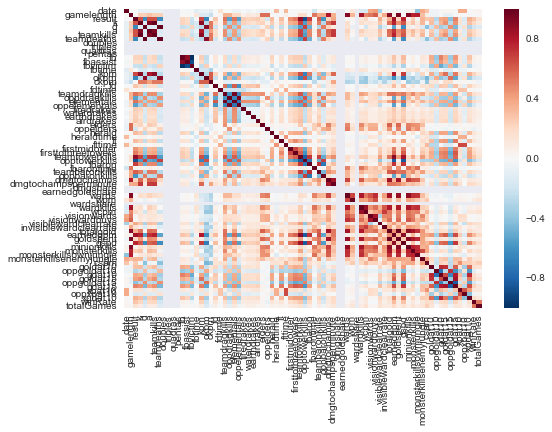

In [75]:
corr = teamDF.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [78]:
# corr.result.sort_values()
temp = pd.concat([corr.result, corrResult], keys=['corr', 'binCorr'], axis = 'columns')
temp.dropna(how = 'any', inplace= True, axis = 'rows')
temp = temp.round(6)


0.26258011748320792

There's definitely a lot of correlation happening between the independent variables. This makes sense as game duration dependent variables are going to be highly correlated - the longer the game goes, the higher the values we can expect for deaths, assists, kills, earned gold, gold spent, minions killed, etc.

Because this correlation between IV's can be more than merely pairwise, it won't suffice to merely remove the correlated IV's seen in the heatmap above. Instead, we'll build a basic regression and evaluate IV's by Variance Inflation Factor (V.I.F).

We'll start by dropping the non-numeric columns from the analysis, since VIF won't work with categorical data.

In [ ]:
reg_teamDF = teamDF.copy()
reg_teamDF = reg_teamDF._get_numeric_data()

print(reg_teamDF.head())
print(reg_teamDF.columns)

There's a few columns in there that are all NaN (these are all columns that have values in playerDF but not in teamDF). We won't be needing these columns either.

In [ ]:
reg_teamDF.dropna(axis = 'columns', how = 'all', inplace = True)
print(reg_teamDF.info())

The remaining columns are all numerical, but the erroneous 'date' column isn't going to be much use as a predictor, so we'll go ahead and remove that too.

In [ ]:
reg_teamDF = reg_teamDF.loc[:,'gamelength':]

Next, we'll use the dmatrices function from the patsy module to create a multiple regression, assigning the output to an outcome dataframe and a predcitor dataframe.

In [ ]:
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = "+".join([x for x in list(reg_teamDF) if x != 'result'])
outcome, pred = dmatrices('result ~' + cols, reg_teamDF, return_type='dataframe')

We'll create a new dataframe, 'vif' to store the variance inflation factors and their respective labels.

In [ ]:
vif = pd.DataFrame()
vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
vif["Regressor"] = pred.columns

vif.round(3)

Our concerns of multicolinearity in the data have definitely been confirmed by the many IV's of the regression observed to have high VIF values. If we consider the math behind VIF's:

<center>$$ VIF_k=\frac{1}{1-R_{k}^{2}} $$</center>

Where $R_{k}^{2}$ is the $R^{2}$ obtained from performing a regression on the k<sup>th</sup> IV using all other remaining IV's. This means the more correlated an IV is with the other IV's, the higher it's VIF value will be.

However, this first stab at VIF testing has revealed another problem. Many of the regressors have VIF's of inf. That would require an $R^2$ of 1 and since it is extremely unlikely that the other IV's are perfect predictors of each other, something else is going on - NaN's. The dmatrices() function is likely unable to do a regression on an outcome variable that contains NaN-s, and is defaulting its $R^2$ to 1. We will have to either drop all columns containing NaN's, or impute missing values. We will go with imputing.

First, we'll check the outliers in the missing columns to determine whether mean or median imputation is preferrable in each. We'll call a column value an outlier if it is more than 3 standard deviations from the mean.

Now that the NaN's have been imputed, let's try our original VIF evaluation again. Since we're going to repeat the same operations over and over again, let's functionize it.

In [ ]:
def get_vif(df, regressors, response):
    # Where df is a dataframe, regressors is a list of strings representing columns
    # in df, and response is a string representing the outcome column in df.
    cols = "+".join(regressors)
    outcome, pred = dmatrices(response + ' ~' + cols, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["Regressor"] = pred.columns
    return vif.round(3).sort_values(by = 'Variance Inflation Factor', ascending = False )

#     cols = "+".join([x for x in list(reg_teamDF) if x != 'result'])
#     outcome, pred = dmatrices('result ~' + cols, reg_teamDF, return_type='dataframe')
#     vif = pd.DataFrame()
#     vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
#     vif["Regressor"] = pred.columns
#     return vif.round(3)

Okay, let's use our new get_vif() function to check VIF on the updated dataframe.

In [ ]:
regressors = [x for x in list(reg_teamDF) if x != 'result']
get_vif(reg_teamDF, regressors, 'result')

Still having the same problem of infinite VIF values. In case the problem was actually being caused by integer dtypes, let's try converting them to floats.

In [ ]:
reg_teamDF = reg_teamDF.astype('float64')
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

And the same problem persists. Okay, let's proceed as if it's not an issue and continue VIF evaluation by removing (finite) high VIF value regressors, starting with 'wards'.

In [ ]:
regressors = list(set(regressors) - set(['wards']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

In [ ]:
regressors = list(set(regressors) - set(['totalgold']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

In [ ]:
regressors = list(set(regressors) - set(['wardkills', 'dmgtochamps', 'goldspent', 'minionkills']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

Okay, this approach isn't doing anything to eliminate the infinite VIF's. It seems rather obvious now, but I realize the reason for those values is because some of the columns really __are__ perfect predictors of each other. For instance, 'elementals' is the sum of earthdrakes, airdrakes, and firedrakes. Let's test this.

In [ ]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

Huzzah! Finally getting somewhere with the infinite VIF's. Looking at the other probelm regressors, I realize now that 'teamdeaths' and 'd' are actually the same values, as are 'teamkills' and 'k'. 'ckpm' (combined kills per minute) is the sum of 'okpm' and 'kpm' (opponent kills per minute and kills per minute). 'fb' and 'fbvictim' are perfectly inversely related.

In [ ]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

Next we can see that the columns representing gold and opponent gold at 10 or 15 minutes ('goldat15', 'goldat10', 'xpat10', 'oppgoldat15', 'oppgoldat10', 'oppxpat10') can be perfectly predicted by themselves and the differential columns ('gdat10', 'gdat15' 'xpdat10'). Let's remove the differential columns.

In [ ]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

Viola! The infinite VIF's are gone.

Now to remove the other high VIF predictors that may be creating multicollinearity. We'd like to get to a point where most VIF's are less than 5, and none are over 10. Currently there are 20 greater than 10, so there's some trimming to do.

There are a lot of predictors closely related to 'wards','minionkills', and 'totalgold', as well as many rate of time type columns that will be strongly influenced by 'gamelength'. The high VIF's of these predictors support this assessement. So let's remove all of those columns.

In [ ]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills', 'totalgold','gamelength']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

Okay, down to 12.

Now we can see 'dmgtochamps' and 'dmgtochampsperminute' which perfectly related by 'gamelength'. The same applies to 'teamkills' and 'kpm', as well as 'teamdeaths' and 'okpm', and 'wardkills' for 'wcpm'. We'll take out the non-rate-of-time version for each of these statistics.

We also see 'monsterkills' is derived from 'monsterkillsownjungle' and 'monsterkillsenemyjungle'.

In [ ]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim',
                                               'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills',
                                               'totalgold','gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths', 'wardkills', 'monsterkills']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

***
# In Progress Miscellaneous

### Macro strategies to impact game outcome

I would like to investigate if there are playstyle strategies available to teams that will improve their likelihood of winning. In american football for instance, bad teams - meaning those with lower records - are statistically more likely to beat a good opponent by raising the variance of the game through things like trick plays, unexpected onside kicks, aggressive throw selection, 4th down calls, etc. I'm interested in seeing if there are extensions of this in competitive League of Legends.

For instance, are the best teams (top quartile of win pct) more or less likely to win longer games? The same question with 'bloodier' (high values for 'ckpm' - combined kills per minute) games.

First, let's get an idea of the distributions of gamelength and ckpm.

In [ ]:
plt.hist(teamDF['gamelength'], bins = 'fd', normed = True)
plt.xlabel("Game Length (minutes)")
plt.show()

In [ ]:
plt.hist(teamDF['ckpm'].dropna(), bins = 'fd', normed = True)
plt.xlabel("Combined Kills Per Minute")
plt.show()

In [ ]:
#df.to_excel(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep19.xlsx')

In [ ]:
#df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep25.csv')